In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numba import njit, prange
from pathlib import Path
from scipy.linalg import expm

# Define constants
time_length = 10
time_increment = 0.01
time_steps = int(time_length / time_increment)
time_array = np.linspace(0, time_length, time_steps)

H_plus_matrix = np.diag([1,0,0,1])
H_minus_matrix = np.diag([0,1,-1,0])
J_matrix = np.array([[1,0,0,0],[0,-1,2,0],[0,2,-1,0],[0,0,0,1]])


def compute_value_O1(t, H1=1, H2=2, J=1, BS=None):
    """
    Computes the unitary transformation of the state BS under the Hamiltonian H without using expm().
    
    Parameters:
    - t (float): Time parameter.
    - H1 (float): Parameter for H_plus component.
    - H2 (float): Parameter for H_minus component.
    - J (float): Coupling constant.
    - BS (np.ndarray): State vector to be transformed.
    
    Returns:
    - np.ndarray: Transformed state vector.
    """
    # Compute the diagonal elements for states 0 and 3
    c = H1 + H2 + J
    e_diag = np.exp(1j * c * t)
    
    # Compute parameters for the 2x2 block
    a = H1 - H2
    omega = np.sqrt(a**2 + 4 * J**2)
    
    # Compute the exponential for the 2x2 block
    e_block_factor = np.exp(-1j * J * t)
    cos_term = np.cos(omega * t)
    sin_term = np.sin(omega * t)
    
    # Define the 2x2 Hamiltonian block
    H_block = np.array([
        [a, 2 * J],
        [2 * J, -a]
    ])
    
    # Normalize the Hamiltonian block
    H_block_normalized = H_block / omega
    
    # Compute the 2x2 exponential
    e_block = e_block_factor * (cos_term * np.eye(2) + 1j * H_block_normalized * sin_term)
    
    # Construct the full 4x4 unitary matrix
    u_matrix = np.eye(4, dtype=complex)
    u_matrix[0, 0] = e_diag
    u_matrix[3, 3] = e_diag
    u_matrix[1:3, 1:3] = e_block
    
    # Apply the unitary transformation to BS
    return u_matrix @ BS


def compute_value(t,H1=1, H2=2, J=1, BS=None):
    H_matrix = (H1+H2) * H_plus_matrix + (H1-H2)*H_minus_matrix + J*J_matrix
    H_matrix_np = np.array(H_matrix, dtype=complex)
    u_matrix = expm(1j * H_matrix_np * t)
    return u_matrix @ BS


def GenValues(H1=1, H2=2, J=1, BS=None):
    if BS is None:
        BS = np.array([[1], [0], [0], [0]])

    if(np.linalg.norm(BS) > 1):
        BS = BS / np.linalg.norm(BS)
    

    # Preallocate arrays for performance
    phases = np.zeros((4, time_steps))
    magnitudes = np.zeros((4, time_steps))
    sum_of_squares = np.zeros(time_steps)

    # Loop once over time steps
    for idx, t in enumerate(time_array):
        res = compute_value_O1(t, H1=H1, H2=H2, J=J, BS=BS)

        # Flatten the result to 1D array for easy indexing
        res_flat = res.flatten()

        # Extract phases and magnitudes for all components at once
        phases[:, idx] = np.angle(res_flat)
        magnitudes[:, idx] = np.abs(res_flat)
        sum_of_squares[idx] = magnitudes[0,idx] ** 2 + magnitudes[1,idx] ** 2 + magnitudes[2,idx] ** 2 + magnitudes[3,idx] ** 2

    return phases, magnitudes, sum_of_squares



In [2]:
import sympy as sp
from sympy import Matrix, I, symbols, factorial
from IPython.display import display, Markdown


# Define symbols
t, H1, H2, J = sp.symbols('t H1 H2 J', real=True)

# Define matrices
H_plus = Matrix.diag(1, 0, 0, 1)
H_minus = Matrix.diag(0, 1, -1, 0)
J_matrix = Matrix([
    [1, 0, 0, 0],
    [0, -1, 2, 0],
    [0, 2, -1, 0],
    [0, 0, 0, 1]
])

# Define the Hamiltonian matrix
H = (H1 + H2) * H_plus + (H1 - H2) * H_minus + J * J_matrix
#display(Markdown(f"$$\n{sp.latex((H1 + H2) * H_plus)}\n$$"))
#display(Markdown(f"$$\n{sp.latex((H1 - H2) * H_minus )}\n$$"))
#display(Markdown(f"$$\n{sp.latex(J * J_matrix)}\n$$"))


display(Markdown(f"$$\n{sp.latex(H)}\n$$"))
print(sp.latex(H))


# Identity matrix
I_matrix = sp.eye(H.shape[0])

# Compute the Taylor series for e^(i H t)
u_matrix = I_matrix  # Start with the identity matrix

n_terms = 4# Number of terms in the Taylor series
for n in range(1, n_terms):
    u_matrix += (I * H * t)**n / sp.factorial(n)

# Generate LaTeX code for the Taylor expansion of the matrix exponential

# Display the LaTeX code in a Markdown cell

#from IPython.display import display, Markdown
#display(Markdown(f"$$\n{sp.latex(u_matrix)}\n$$"))


$$
\left[\begin{matrix}H_{1} + H_{2} + J & 0 & 0 & 0\\0 & H_{1} - H_{2} - J & 2 J & 0\\0 & 2 J & - H_{1} + H_{2} - J & 0\\0 & 0 & 0 & H_{1} + H_{2} + J\end{matrix}\right]
$$

\left[\begin{matrix}H_{1} + H_{2} + J & 0 & 0 & 0\\0 & H_{1} - H_{2} - J & 2 J & 0\\0 & 2 J & - H_{1} + H_{2} - J & 0\\0 & 0 & 0 & H_{1} + H_{2} + J\end{matrix}\right]


In [3]:
Taylor_func = sp.lambdify((t, H1, H2, J), u_matrix, 'numpy')



def taylor_compute(t,H1,H2,J, BS):
    if(np.linalg.norm(BS) > 1):
        BS = BS / np.linalg.norm(BS)
    return Taylor_func(t,H1,H2,J) @ BS

def GenValuesTaylor(H1=1, H2=2, J=1, BS=None):
    if BS is None:
        BS = np.array([[1], [0], [0], [0]])

    if(np.linalg.norm(BS) > 1):
        BS = BS / np.linalg.norm(BS)
    

    # Preallocate arrays for performance
    phases = np.zeros((4, time_steps))
    magnitudes = np.zeros((4, time_steps))
    sum_of_squares = np.zeros(time_steps)

    # Loop once over time steps
    for idx, t in enumerate(time_array):
        res = taylor_compute(t, H1=H1, H2=H2, J=J, BS=BS)

        # Flatten the result to 1D array for easy indexing
        res_flat = res.flatten()

        # Extract phases and magnitudes for all components at once
        phases[:, idx] = np.angle(res_flat)
        magnitudes[:, idx] = np.abs(res_flat)
        sum_of_squares[idx] = magnitudes[0,idx] ** 2 + magnitudes[1,idx] ** 2 + magnitudes[2,idx] ** 2 + magnitudes[3,idx] ** 2

    return phases, magnitudes, sum_of_squares



In [4]:
taylor_result = taylor_compute(0.3,1,1,1,BS=[1,1,1,1])
compute_result = compute_value(0.3,1,1,1,BS=[1,1,1,1])


# Convert to NumPy arrays (if they aren't already)
taylor_result = np.array(taylor_result)
compute_result = np.array(compute_result)

np.set_printoptions(precision=2, suppress=True)


print("Compute Value O1 Result:")
print(compute_result)

print("\nTaylor Compute Result:")
print(taylor_result)

print("The Sum of Square Errors is: " + 
    str(np.abs(   (taylor_result[0] - compute_result[0])**2 + (taylor_result[1] - compute_result[1])**2 + (taylor_result[2] - compute_result[2])**2 + (taylor_result[3] - compute_result[3])**2)))


Compute Value O1 Result:
[0.62+0.78j 0.96+0.3j  0.96+0.3j  0.62+0.78j]

Taylor Compute Result:
[0.3 +0.39j 0.48+0.15j 0.48+0.15j 0.3 +0.39j]
The Sum of Square Errors is: 0.8526607041103698


In [8]:
import pprint
import pandas as pd



def SavePlot(H1,H2,J,BS):
    BS = np.array(BS)
    phases,magnitudes,sum_of_squares = GenValuesTaylor(H1=H1,H2=H2, J = J, BS=BS)

    title = f"Parameters: H1={H1}, H2={H2}, J={J}, BS={BS.flatten()}"
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    fig.suptitle(
        f"Plots of Phases, Magnitudes, and Sum of Squares\n"
        f"Parameters: H1={H1}, H2={H2}, J={J}, BS={BS.flatten()}",
        fontsize=9,
        fontweight='bold'
    )


    axs[0].plot(time_array, phases[0,:],linestyle='--', alpha=0.7, label='Alpha')
    axs[0].plot(time_array, phases[1,:],linestyle='-', alpha=0.7, label='Beta')
    axs[0].plot(time_array, phases[2,:],linestyle='-.', alpha=0.7, label='D')
    axs[0].plot(time_array, phases[3,:],linestyle=':', alpha=0.7, label='C')
    axs[0].grid(True)
    axs[0].set_title('Phases')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Phase')
    axs[0].legend()

    axs[1].plot(time_array, magnitudes[0,:],linestyle='--', alpha=0.7, label='Alpha')
    axs[1].plot(time_array, magnitudes[1,:],linestyle='-', alpha=0.7, label='Beta')
    axs[1].plot(time_array, magnitudes[2,:],linestyle='-.', alpha=0.7, label='D')
    axs[1].plot(time_array, magnitudes[3,:],linestyle=':', alpha=0.7, label='C')
    axs[1].grid(True)
    axs[1].set_title('Magnitudes')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Phase')
    axs[1].legend()

    axs[2].set_ylim(0.5, 1.5)
    axs[2].plot(time_array, sum_of_squares)
    axs[2].grid(True)
    axs[2].set_title('Sum of Squares')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Squares')

    plt.savefig(fname="./Pictures/" + title + ".png",format='png',)
    plt.close()

    

SavePlot(H1=1,H2=1, J = 1, BS=[1,0,0,1])





FileNotFoundError: [Errno 2] No such file or directory: '/Users/mwd/Programming/Senior-Project/Pictures/Parameters: H1=0, H2=0, J=1, BS=[0 0 0 0].png'

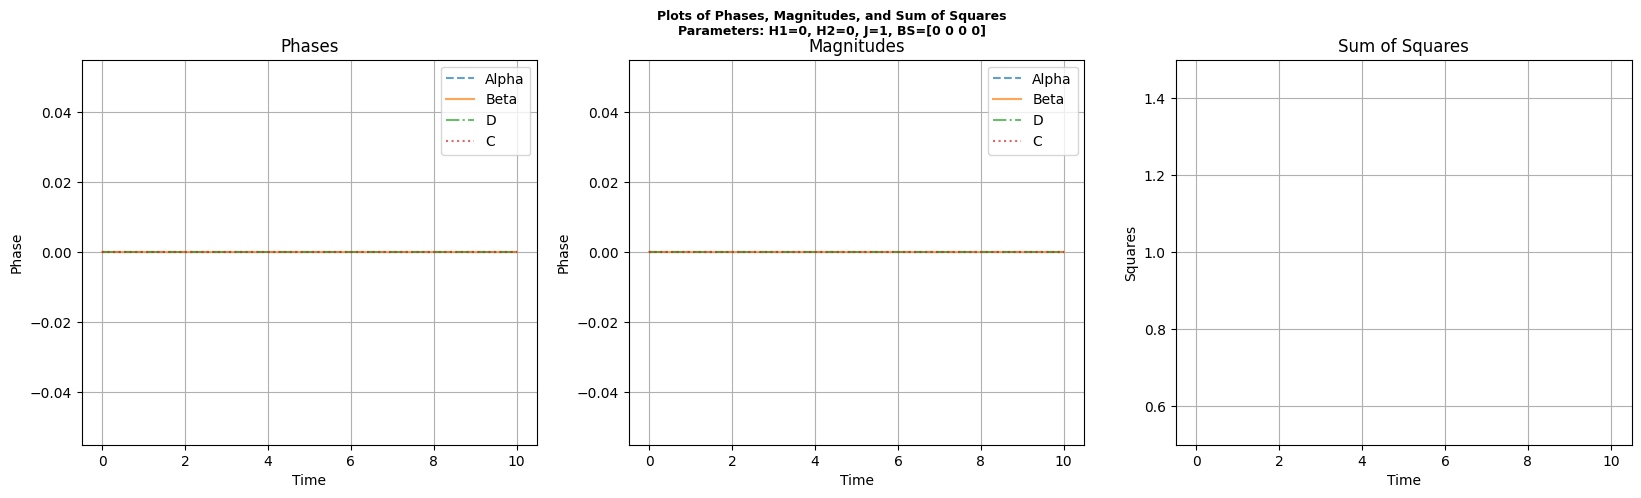

In [10]:
import itertools
import numpy as np
# Generate all possible combinations of a 4-element column vector with elements 0 or 1
combinations = list(itertools.product([0, 1], repeat=4))
# Convert each combination to a 4x1 NumPy array and print
column_vectors = [np.array(comb).reshape(4, 1) for comb in combinations]

first_three_combinations = list(itertools.product([0, 1], repeat=3))
# Filter out combinations where all first three values are zero
filtered_first_three_combinations = [
    comb for comb in first_three_combinations
    if not (comb[0] == 0 and comb[1] == 0 and comb[2] == 0)  # Filter all-zero combination
    and not (comb[0] == 1 and comb[1] == 1 and comb[2] == 0)  # Filter (1, 1, 0)
]# Generate all combinations of four values by pairing filtered first three combinations with each array in column_vectors
all_combinations = [
    first_three + (fourth_value,)
    for first_three in filtered_first_three_combinations
    for fourth_value in column_vectors
]

for combination in all_combinations:
    SavePlot(*combination)
